<a href="https://colab.research.google.com/github/kiyong21c/kaggle/blob/main/20220616_porto-seguro-safe-driver-prediction-improve.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

# 안전운전자 예측
 - 실제 보험사에서 제공한 고객 데이터 활용하여 운전자가 보험을 청구할 확률 예측
 - 문제유형 : 이진분류
 - 평가지표 : 정규화된 지니계수
 - 사용모델 : LightGBM, XGBoost의 앙상블

## 성능 개선 1 : LightGBM 모델
 - 피처 엔지니어링, 하이퍼파라미터 최적화

In [4]:
import pandas as pd

data_path = '/content/drive/MyDrive/Colab Notebooks/kaggle/input/porto-seguro-safe-driver-prediction/'

train = pd.read_csv(data_path + 'train.csv', index_col='id')
test = pd.read_csv(data_path + 'test.csv', index_col='id')
submission = pd.read_csv(data_path + 'sample_submission.csv', index_col='id')

### 피처 엔지니어링

#### 데이터 합치기

In [5]:
all_data = pd.concat([train, test], ignore_index=True)
all_data = all_data.drop('target', axis=1)

all_features = all_data.columns

#### 명목형 피처 원-핫 인코딩

In [6]:
from sklearn.preprocessing import OneHotEncoder

# 명목형 피처
cat_features = [feature for feature in all_features if 'cat' in feature]

# 원-핫 인코딩 적용
onehot_encoder = OneHotEncoder()
encoded_cat_matrix = onehot_encoder.fit_transform(all_data[cat_features])

#### 파생 피처 추가
 - 기존 : 필요 없는 피처 제거
 - 성능 향상을 위한 추가적인 방법 몇가지
 - 1. 한 데이터가 가진 결측값 개수를 파생 피처로

In [7]:
# 데이터 하나당(한사람당) 결측값 개수를 파생 피처로 추가
all_data['num_missing'] = (all_data==-1).sum(axis=1) # axis=0 : 컬럼 단위로, axis=1 : 행 단위로

In [8]:
# 명목형 피처, calc 분류의 피처를 제외한 피처
remaining_features = [feature for feature in all_features
                      if ('cat' not in feature and 'calc' not in feature)]

# num_missing을 remaining_features에 추가
remaining_features.append('num_missing')

In [9]:
remaining_features

['ps_ind_01',
 'ps_ind_03',
 'ps_ind_06_bin',
 'ps_ind_07_bin',
 'ps_ind_08_bin',
 'ps_ind_09_bin',
 'ps_ind_10_bin',
 'ps_ind_11_bin',
 'ps_ind_12_bin',
 'ps_ind_13_bin',
 'ps_ind_14',
 'ps_ind_15',
 'ps_ind_16_bin',
 'ps_ind_17_bin',
 'ps_ind_18_bin',
 'ps_reg_01',
 'ps_reg_02',
 'ps_reg_03',
 'ps_car_11',
 'ps_car_12',
 'ps_car_13',
 'ps_car_14',
 'ps_car_15',
 'num_missing']

 - 2. 모든 ind피처 값을 연결해 새로운 피처로 만들자
 
  > ps_ind_01, ps_ind_02_cat, ps_ind_03의 값이 각각 2, 2, 5라면 모든값을 연결해 2_2_5로 만든다

  > ind피처가 총 18개 이므로 18개 값 연결

  > 새로운 피처명 'mix_ind' : 임시

In [10]:
# 전체 피처 중에 분류가 ind인 피처 
ind_features = [feature for feature in all_features if 'ind' in feature]

is_first_feature = True     # 반복문 바깥에서 True 지정 후 반복문내에서 False 변경: 이러한 포맷은 반복문에서 특정상황을 한번 초기화 한 후 반복하려 할때 주로 사용
for ind_feature in ind_features:
    if is_first_feature:
        all_data['mix_ind'] = all_data[ind_feature].astype(str) + '_' # 1.특정상황 한번 초기화
        is_first_feature = False                                      # 2. False로 변경
    else:
        all_data['mix_ind'] += all_data[ind_feature].astype(str) + '_'# 3. else: 즉, False이므로 반복 수행

In [11]:
all_data['mix_ind']

0          2_2_5_1_0_0_1_0_0_0_0_0_0_0_11_0_1_0_
1           1_1_7_0_0_0_0_1_0_0_0_0_0_0_3_0_0_1_
2          5_4_9_1_0_0_0_1_0_0_0_0_0_0_12_1_0_0_
3           0_1_2_0_0_1_0_0_0_0_0_0_0_0_8_1_0_0_
4           0_2_0_1_0_1_0_0_0_0_0_0_0_0_9_1_0_0_
                           ...                  
1488023     0_1_6_0_0_0_1_0_0_0_0_0_0_0_2_0_0_1_
1488024    5_3_5_1_0_0_0_1_0_0_0_0_0_0_11_1_0_0_
1488025     0_1_5_0_0_1_0_0_0_0_0_0_0_0_5_0_0_1_
1488026    6_1_5_1_0_0_0_0_1_0_0_0_0_0_13_1_0_0_
1488027    7_1_4_1_0_0_0_0_1_0_0_0_0_0_12_1_0_0_
Name: mix_ind, Length: 1488028, dtype: object

 - 3. 명목형 피처의 고윳값별 개수를 새로운 피처로 추가
 
  > 고윳값 : -1, 1, 2, 3, 4 

  > 각 고윳값의 개수 : 523, 1079327, 309747, 70172, 28259

  > 새로운 피처에는 값이 -1이면 523으로 바꿔넣음

In [12]:
# 'ps_ind_02_cat' 피처를 예로들어 보자
all_data['ps_ind_02_cat'].value_counts() # 각 고윳값이 몇개인지 Series로 나타냄

 1    1079327
 2     309747
 3      70172
 4      28259
-1        523
Name: ps_ind_02_cat, dtype: int64

In [13]:
all_data['ps_ind_02_cat'].value_counts().to_dict() # 인덱스와 데이터를 딕셔너리 타입으로 바꿔줌

{-1: 523, 1: 1079327, 2: 309747, 3: 70172, 4: 28259}

 - 이전에 추가한 mix_ind 피처도 명목형 피처
 - 인코딩전의 cat_features 피처도 명목형 피처

In [14]:
cat_count_features = []
for feature in cat_features+['mix_ind']:
    val_counts_dict = all_data[feature].value_counts().to_dict()
    all_data[f'{feature}_count'] = all_data[feature].apply(lambda x: val_counts_dict[x]) # apply앞의 Series의 값을 딕셔너리의 Key로 받음 
    
    # cat_count_features 새로운 피처명 리스트 추가
    cat_count_features.append(f'{feature}_count')

In [15]:
cat_count_features

['ps_ind_02_cat_count',
 'ps_ind_04_cat_count',
 'ps_ind_05_cat_count',
 'ps_car_01_cat_count',
 'ps_car_02_cat_count',
 'ps_car_03_cat_count',
 'ps_car_04_cat_count',
 'ps_car_05_cat_count',
 'ps_car_06_cat_count',
 'ps_car_07_cat_count',
 'ps_car_08_cat_count',
 'ps_car_09_cat_count',
 'ps_car_10_cat_count',
 'ps_car_11_cat_count',
 'mix_ind_count']

##### 참고
 - Series에 apply() 함수적용시 lambda를 사용하는 방법
 - Series가 Dictionary 일때 헷갈리지 않게 정리해보자

In [16]:
val_counts_dict = all_data['ps_ind_02_cat'].value_counts().to_dict()
all_data['ps_ind_02_cat'].apply(lambda x: val_counts_dict[x]) # Series.apply(lambda x: return dict[x]) : 
# lambda x의 의미 → x를 파라미터로 받는 함수
# lambda x: 의 의미 → :x를 파라미터로 받는 함수이며, ":"이후를 return 하는 함수(return이 생략되어 있음)
# x를 파라미터로 받아서 dict[x]에 집어넣는다.
# Series.apply(func(x))에서 x는 "Series의 값"

0           309747
1          1079327
2            28259
3          1079327
4           309747
            ...   
1488023    1079327
1488024      70172
1488025    1079327
1488026    1079327
1488027    1079327
Name: ps_ind_02_cat, Length: 1488028, dtype: int64

In [17]:
all_data['ps_ind_02_cat']

0          2
1          1
2          4
3          1
4          2
          ..
1488023    1
1488024    3
1488025    1
1488026    1
1488027    1
Name: ps_ind_02_cat, Length: 1488028, dtype: int64

#### 필요 없는 피처 제거
 - 지금 까지 만든 피처

  > encoded_cat_matrix : 원-핫 인코딩된 명목형 피처

  > remaining_features : 명목형 피처와 calc 분류의 피처를 제외한 피처들(+num_missing)

  > cat_count_features : mix_ind를 포함한 명목형 피처의 고윳값별 개수 파생 피처

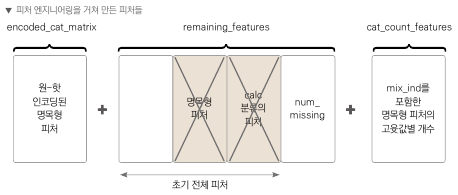

In [18]:
from scipy import sparse

# 탐색적 데이터 분석을 통해 필요 없다고 판단된 피처
drop_features = {'ps_ind_14','ps_ind_10_bin','ps_ind_11_bin',
                 'ps_ind_12_bin','ps_ind_13_bin','ps_car_14'}

# remaining_features, cat_count_features에서 drop_features를 제거한 데이터
all_data_remaining = all_data[remaining_features+cat_count_features].drop(drop_features, axis=1)

# 원-핫 인코딩된 명목형 피처 데이터와 합치기
all_data_sprs = sparse.hstack([sparse.csr_matrix(all_data_remaining), # DataFrame → CSR
                               encoded_cat_matrix], # 원-핫 인코딩하면서 CSR됨
                              format='csr')

#### 데이터 나누기

In [19]:
num_train = len(train) # 훈련 데이터 개수

# 훈련데이터와 테스트데이터 나누기
X = all_data_sprs[:num_train]
X_test = all_data_sprs[num_train:]

y = train['target'].values

### 하이퍼파라미터 최적화
 - 베이지안 최적화 기법 활용 : 그리드 서치보다 빠르고 효율적, 코드가 직관적

#### 데이터셋 준비

In [20]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split

# 8:2 비율 훈련/데이터 분리 (베이지안 최적화 수행용)
X_train, X_valid, y_train, y_valid = train_test_split(X, y,
                                                     test_size=0.2,
                                                     random_state=0)

# 베이지안 최적화 전용 데이터셋
bayes_dtrain = lgb.Dataset(X_train, y_train)
bayes_dvalid = lgb.Dataset(X_valid, y_valid)

#### 하이퍼파라미터 범위 설정
 - 처음부터 설정하는 것은 어렵다
 - 1. 하이퍼 파라미터 범위를 점점 좁히기

  > 0-1 범위에서 0.5를 최적의 하이퍼파라미터로 찾았다면, 다시 0.4-0.6 에서 다시 수행

 - 2. 상위권 캐글러가 설정한 파라미터 참고

In [21]:
# 베이지안 최적화를 위한 하이퍼파라미터 범위
param_bounds = {'num_leaves':(30,40),
                'lambda_l1':(0.7,0.9),
                'lambda_l2':(0.9,1),
                'feature_fraction':(0.6, 0.7),
                'bagging_fraction':(0.6, 0.9),
                'min_child_samples':(6,10),
                'min_child_weight':(10,40)}

# 값이 고정된 하이퍼파라미터
fixed_params = {'objective':'binary',
                'learning_rate':0.005,          # 학습률은 보통 0.01~0.001
                'bagging_freq':1,
                'force_row_wise':True,          # 경고 문구를 없애기 위함
                'random_state':1991}            # 다시 수행해도 동일한 값을 위해

##### 평가지표 계산 함수 : 정규화된 지니계수


In [22]:
# 실제 타깃값(y_true)와 예측 확률값(y_pred) 입력받아 정규화 지니계수 반환
import numpy as np

def eval_gini(y_true, y_pred):
    assert y_true.shape == y_pred.shape # assert : True가 아니면 오류 발생

    n_samples = y_true.shape[0] # 데이터 개수
    L_mid = np.linspace(1/n_samples, 1, n_samples) # 대각선 값

    # 1) 예측값에 대한 지니계수
    pred_order = y_true[y_pred.argsort()] # y_pred.argsort() : y_pred배열 오름차순 인덱스값 배열
    # 즉, y_pred 크기순으로 y_true 정렬
    L_pred = np.cumsum(pred_order) / np.sum(pred_order) # 로렌츠 곡선
    G_pred = np.sum(L_mid - L_pred) # 예측값에 대한 지니계수

    # 2) 예측이 완벽할 때 지니계수
    true_order = y_true[y_true.argsort()] # y_true 크기순으로 y_true 값 정렬
    L_true = np.cumsum(true_order) / np.sum(true_order) # 로렌츠 곡선
    G_true = np.sum(L_mid - L_true) # 예측이 완벽할 때 지니계수

    # 정규화된 지니계수
    return G_pred / G_true

In [23]:
# LightGBM용 gini() 함수
def gini(preds, dtrain):
    labels = dtrain.get_label()
    return 'gini', eval_gini(labels, preds), True
    # 평가지표이름, 평가점수, 평가점수가 높을수록 좋은지여부?
    # 이후 lightGBM의 훈련시 feval 파라미터로 들어가는 함수로써 3가지 값을 요구함

#### (베이지안 최적화용) 평가지표 계산함수 작성
 - param_bounds를 순회하며 최적의 하이퍼파라미터 값을 적용해 모델을 훈련 → 훈련된 모델로 성능을 평가하기위한 평가지표 필요

 - eval_function()은 베이지안 최적화를 수행하기 위한 평가지표(지니계수) 계산함수
  > 이 함수로 지니계수를 계산해 최적 하이퍼파라미터 찾는다

  > 최적화하려는 LightGBM모델의 하이퍼파라미터 7개를 인수로 받고 지니계수 반화

In [24]:
def eval_function(num_leaves, lambda_l1, lambda_l2, feature_fraction,
                  bagging_fraction, min_child_samples, min_child_weight): # 베이지안 최적화를 위해 확인해볼 하이퍼 파라미터들

    # 베이지안 최적화를 수행할 하이퍼파라미터
    params = {'num_leaves' : int(round(num_leaves)),    # num_leaves, min_child_samples는 정수여야 함
              'lambda_l1' : lambda_l1,
              'lambda_l2' : lambda_l2,
              'feature_fraction' : feature_fraction,
              'bagging_fraction' : bagging_fraction,
              'min_child_samples' : int(round(min_child_samples)),
              'min_child_weight' : min_child_weight,
              'feature_pre_filter' : False}

    # 고정된 하이퍼파라미터도 추가
    params.update(fixed_params) # 딕셔너리에 합칠시 update()

    print('하이퍼파라미터:', params)


    # LightGBM 모델 훈련
    lgb_model = lgb.train(params=params,
                          train_set=bayes_dtrain,
                          num_boost_round=2500,
                          valid_sets=bayes_dvalid,
                          feval=gini,
                          early_stopping_rounds=300,
                          verbose_eval=False)
    
    # 검증 데이터로 예측 수행
    preds = lgb_model.predict(X_valid)

    # 지니계수 계산
    gini_score = eval_gini(y_valid, preds)
    print(f'지니계수 : {gini_score}\n')

    return gini_score


#### 최적화 수행
 - 1.하이퍼파라미터 범위 설정 : param_bounds
 - 2.평가지표 계산 함수 : eval_function()
 - 3.베이지안 최적화 객체 생성(파라미터 : param_bounds, eval_function)

##### 베이지안 최적화 관련 모듈 설치

In [25]:
pip install bayesian-optimization

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-py3-none-any.whl size=11685 sha256=722f58e02836d04717b93c2b5afab7f6e6ccb153fc8869be0a8f682a6980e035
  Stored in directory: /root/.cache/pip/wheels/fd/9b/71/f127d694e02eb40bcf18c7ae9613b88a6be4470f57a8528c5b
Successfully built bayesian-optimization


In [26]:
from bayes_opt import BayesianOptimization

# 베이지안 최적화 객체 생성
optimizer = BayesianOptimization(f=eval_function,       # 평가지표 계산 함수
                                 pbounds=param_bounds,  # 하이퍼파라미터 범위
                                 random_state=0)

In [27]:
optimizer.maximize(init_points=3, n_iter=6) # init_points : 무작위로 하이퍼파라미터 탐색하는 횟수, n_iter : 베이지안 최적화 반복횟수
# 베이지안 최적화는 init_points와 n_iter를 더한 값만큼 반복, 총9회 반복

|   iter    |  target   | baggin... | featur... | lambda_l1 | lambda_l2 | min_ch... | min_ch... | num_le... |
-------------------------------------------------------------------------------------------------------------
하이퍼파라미터: {'num_leaves': 34, 'lambda_l1': 0.8205526752143287, 'lambda_l2': 0.9544883182996897, 'feature_fraction': 0.6715189366372419, 'bagging_fraction': 0.7646440511781974, 'min_child_samples': 8, 'min_child_weight': 29.376823391999682, 'feature_pre_filter': False, 'objective': 'binary', 'learning_rate': 0.005, 'bagging_freq': 1, 'force_row_wise': True, 'random_state': 1991}
지니계수 : 0.2846778857441302

|  1        |  0.2847   |  0.7646   |  0.6715   |  0.8206   |  0.9545   |  7.695    |  29.38    |  34.38    |
하이퍼파라미터: {'num_leaves': 39, 'lambda_l1': 0.7766883037651555, 'lambda_l2': 0.9791725038082665, 'feature_fraction': 0.6963662760501029, 'bagging_fraction': 0.867531900234624, 'min_child_samples': 8, 'min_child_weight': 27.04133683281797, 'feature_pre_filter': False,

In [28]:
optimizer.max # dict

{'params': {'bagging_fraction': 0.6,
  'feature_fraction': 0.6,
  'lambda_l1': 0.9,
  'lambda_l2': 0.9159110552679353,
  'min_child_samples': 6.0,
  'min_child_weight': 35.14591174568853,
  'num_leaves': 40.0},
 'target': 0.2860104800381049}

In [29]:
optimizer.max.keys() # dict의 key들

dict_keys(['target', 'params'])

In [30]:
optimizer.max['params'] # 지니계수가 최대가 되는, 즉 최적 하이퍼파라미터

{'bagging_fraction': 0.6,
 'feature_fraction': 0.6,
 'lambda_l1': 0.9,
 'lambda_l2': 0.9159110552679353,
 'min_child_samples': 6.0,
 'min_child_weight': 35.14591174568853,
 'num_leaves': 40.0}

In [31]:
max_params = optimizer.max['params']

 - num_leaves, min_child_samples는 원래 정수형 하이퍼파라미터이므로 정수형으로 변환

In [32]:
max_params.update({'num_leaves': int(round(max_params['num_leaves'])),  # 딕셔너리.update({딕셔너리}) : 딕셔너리 변경/추가
                   'min_child_samples': int(round(max_params['min_child_samples']))})

In [33]:
max_params

{'bagging_fraction': 0.6,
 'feature_fraction': 0.6,
 'lambda_l1': 0.9,
 'lambda_l2': 0.9159110552679353,
 'min_child_samples': 6,
 'min_child_weight': 35.14591174568853,
 'num_leaves': 40}

 - 고정된 하이퍼파라미터들(fixed_params) 추가

In [34]:
max_params.update(fixed_params)

In [36]:
max_params

{'bagging_fraction': 0.6,
 'bagging_freq': 1,
 'feature_fraction': 0.6,
 'force_row_wise': True,
 'lambda_l1': 0.9,
 'lambda_l2': 0.9159110552679353,
 'learning_rate': 0.005,
 'min_child_samples': 6,
 'min_child_weight': 35.14591174568853,
 'num_leaves': 40,
 'objective': 'binary',
 'random_state': 1991}

 - 베이지안 최적화를 적용해 구한 최적 하이퍼파라미터

### 모델 훈련 및 성능 검증
 - 그리드 서치와는 달리 베이지안 최적화는 최적 하이퍼파라미터 값들로 훈련된 모델을 제공 하지 않는다
 - 따라서 베이지안 최적화로 찾은 하이퍼파라미터 활용해 LightGBM 모델을 다시 훈련

In [ ]:
from sklearn.model_selection import StratifiedKFold

# 층화 K 폴드 교차검증기 생성
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1991)

# OOF 방식으로 훈련된 모델로 검증 데이터 타깃값을 예측한 확률을 담을 1차원 배열
oof_val_preds = np.zeros(X.shape[0])
# OOF 방식으로 훈련된 모델로 테스트 데이터 타깃값을 예측한 확률을 담을 1차원 배열
oof_test_preds = np.zeros(X_test.shape[0])

# OOF 방식으로 모델 훈련, 검증, 예측
for idx, (train_idx, valid_idx) in enumerate(folds.split(X, y)):
    # 각 폴드를 구분하는 문구 출력
    print('#'*40, f'{idx+1} 폴드 / {folds.n_splits}', '#'*40)
    # 훈련용 데이터, 검증용 데이터 설정
    X_train, y_train = X[train_idx], y[train_idx]   # OOF 방식으로 4/5등분한 테스트 데이터세트
    X_valid, y_valid = X[valid_idx], y[valid_idx]   # OOF 방식으로 1/5등분한 검증용 데이터세트

    # LightGBM 전용 데이터세트 생성
    dtrain = lgb.Dataset(X_train, y_train) # LightGBM 전용 훈련 데이터 세트
    dvalid = lgb.Dataset(X_valid, y_valid) # LightGBM 전용 검증 데이터 세트


    # 각 fold에서 훈련데이터를 통해 LightGBM모델 훈련 : OOF 방식에서 주로 쓰이는 부스팅 모델(LightGBM)
    lgb_model = lgb.train(params=max_params,
                          train_set=dtrain,
                          num_boost_round=2500,
                          valid_sets=dvalid,
                          feval=gini,                  # 검증용 평가지표
                          # gini(preds, dtrain) : gini()는 eval_gini(dtrain.get_label(), preds)을 return함
                          early_stopping_rounds=300,   # 조기종료 조건
                          verbose_eval=100)            # 100번째마다 점수 출력
    
    # 테스트 데이터를 활용해 OOF 예측(훈련된 LightGBM으로 테스트데이터 예측)
    oof_test_preds += lgb_model.predict(X_test)/folds.n_splits # 5번 더해지니까 더할때 마다 5를 나눠줘서 더함
    # 모델 성능 평가를 위한 검증 데이터 타깃값 예측
    oof_val_preds[valid_idx] += lgb_model.predict(X_valid) # oof_val_preds배열의 해당자리에 값이 차도록 함

    # 검증 데이터 예측 확률에 대한 정규화 지니계수 : 모델 성능평가를 정규화 지니계수의 크기로 판단
    gini_score = eval_gini(y_valid, oof_val_preds[valid_idx]) # eval_gini(실제값, 예측값)
    print(f'{idx+1} 폴드, 지니계수 : {gini_score}\n')


######################################## 1 폴드 / 5 ########################################
Training until validation scores don't improve for 300 rounds.
[100]	valid_0's binary_logloss: 0.154268	valid_0's gini: 0.269399
[200]	valid_0's binary_logloss: 0.153181	valid_0's gini: 0.275843
[300]	valid_0's binary_logloss: 0.152576	valid_0's gini: 0.280498
[400]	valid_0's binary_logloss: 0.152218	valid_0's gini: 0.28355
[500]	valid_0's binary_logloss: 0.151979	valid_0's gini: 0.286622
[600]	valid_0's binary_logloss: 0.151816	valid_0's gini: 0.289257
[700]	valid_0's binary_logloss: 0.151701	valid_0's gini: 0.291343
[800]	valid_0's binary_logloss: 0.151617	valid_0's gini: 0.292899
[900]	valid_0's binary_logloss: 0.151549	valid_0's gini: 0.294374
[1000]	valid_0's binary_logloss: 0.151498	valid_0's gini: 0.295459
[1100]	valid_0's binary_logloss: 0.151457	valid_0's gini: 0.296364
[1200]	valid_0's binary_logloss: 0.151423	valid_0's gini: 0.29724
[1300]	valid_0's binary_logloss: 0.1514	valid_0's gin

 - 1폴드 기준으로 최고 지니계수 0.298925
 - OOF 검증 데이터 지니계수
    > OOF방식으로, 검증데이터 전체(전체 훈련데이터)의 예측값과, 실제 검증값으로 eval_gini(y, oof_val_preds)

 - feval = gini(dtrain으로 훈련된 모델의 predict(X_valid), dvalid)

In [1]:
print('OOF 검증 데이터 지니계수 :', eval_gini(y, oof_val_preds))

NameError: ignored

In [45]:
submission['target'] = oof_test_preds
submission.to_csv('submission.csv')

(892816, 217)